# Combined clustering & merging pipeline


### Modules

In [1]:
# Python modules
import os

#### DistantSigMA modules
from misc import utilities as ut
from DistantSigMA.clustering_routine import *
from DistantSigMA.DistantSigMA.cluster_simulations import calculate_std_devs
from DistantSigMA.DistantSigMA.scalefactor_sampling import lhc_lloyd

# Tree/Graph modules
from alex_workspace.ClusterHandler import ClusteringHandler
from alex_workspace.NxGraphAssistant import NxGraphAssistant
from alex_workspace.PlotHandler import PlotHandler
from alex_workspace.Tree import Custom_Tree

## Setup

In [2]:
# Paths
output_path = ut.set_output_path(script_name="combined_pipeline")

run = "combined_pipe_box_0"
output_path = output_path + f"{run}/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

## Data

In [3]:
# load the dataframe
#df_load = pd.read_csv('../Data/Segments/Orion_labeled_segments_KNN_300_15-11-23.csv')
df_load = pd.read_csv(r"C:\Users\Alexm\OneDrive - Universität Wien\01_WINF\Praktikum1\Git2\Distant_SigMA\DistantSigMA\DistantSigMA\Data/Box_0.csv")
# Add new columns with value 1
df_load['pmra_error'] = 1
df_load['pmdec_error'] = 1
df_load['radial_velocity_error'] = 1
df_load['parallax_error'] = 1
# df_load= df_load.reset_index(drop=True)


# load data for error sampling (already slimmed)
error_sampling_df = pd.read_csv(r"C:\Users\Alexm\OneDrive - Universität Wien\01_WINF\Praktikum1\Git2\Distant_SigMA\DistantSigMA\DistantSigMA\Data/Gaia_DR3_1000pc_rs.csv")
#error_sampling_df["dist"] = 1000 / error_sampling_df["parallax"]
#error_sampling_df.to_csv("../Data/Gaia/Gaia_DR3_1000pc_rs.csv")

### Choosing data chunks

## Clustering

Currently written for the scenario that the input is a single chunk without need for further splitting.

### A) Preliminary solution

In [ ]:
# Cluster parameters
dict_prelim = dict(alpha=0.01,
                   beta=0.99,
                   knn_initcluster_graph=35,
                   KNN_list=[15, 20, 25, 30],
                   sfs=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
                   scaling="robust",
                   bh_correction=True)

In [ ]:
chunk = 0
df_chunk = df_load
result_path = output_path

print(f"PART A) Starting clustering ... \n")

df_prelim = run_clustering(region_label=chunk, df_input=df_chunk, sf_params="parallax_scaled",
                           parameter_dict=dict_prelim, mode="prelim", output_loc=result_path)

PART A) Starting clustering ... 

-- Current run with KNN = 15 -- 

Creating k-d trees of resampled data sets...
Performing clustering for scale factor 0.1...
Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 1.00e-05
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 0.15...
Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 1.00e-05
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 0.2...
Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 1.00e-05
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 0.25...
Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 1.00e-05
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 0.3...
Performing gradient ascend using a 15-NN density estimation.
Update

### B) Simulate clusters and determine scale factors

In [ ]:

print(f"PART B) Simulating clusters ... \n")

stds = calculate_std_devs(input_df=df_prelim, SigMA_dict=dict_prelim, sampling_data= error_sampling_df, n_artificial = 1, output_path = result_path, plot_figs = False)

# save scaling factors in Data directory
directory = r"C:\Users\Alexm\OneDrive - Universität Wien\01_WINF\Praktikum1\Git2\Distant_SigMA\DistantSigMA\DistantSigMA\Data/Scale_factors"
filename = f"sfs_region_{chunk}.txt"

# Open the file in write mode ('w')
with open(f"{directory}/{filename}", 'w') as file:
    for i, label in enumerate(["ra", "dec", "parallax", "pmra", "pmdec"]):
        print(f"{label}:", np.min(stds[i, :]), np.mean(stds[i, :]), np.max(stds[i, :]), file=file)

PART B) Simulating clusters ... 



KeyError: 'dist'

### C) Cluster with new SF

In [ ]:
# determine the number of SF to draw using lhc_lloyd sampling
num_sf = 100

-- Current run with KNN = 20 -- 

Creating k-d trees of resampled data sets...
Performing clustering for scale factor p[0.006007194301347941, 0.13205057715099539, 1.6393694254777984][0.25341471024260803, 0.13662604394940758]...
Performing gradient ascend using a 20-NN density estimation.
Creating k-d trees of resampled data sets...
Performing clustering for scale factor p[0.005849791593027561, 0.13258503319171255, 1.5234537449219805][0.2835772585261156, 0.13538788931843954]...
Performing gradient ascend using a 20-NN density estimation.
Creating k-d trees of resampled data sets...
Performing clustering for scale factor p[0.0058633955144854035, 0.11328143539556133, 1.6497889658731428][0.3057685976493958, 0.1442629615081197]...
Performing gradient ascend using a 20-NN density estimation.
Creating k-d trees of resampled data sets...
Performing clustering for scale factor p[0.00643623361148067, 0.1283406746682865, 1.5184707032119715][0.2631104239898311, 0.14741274502196747]...
Performing g

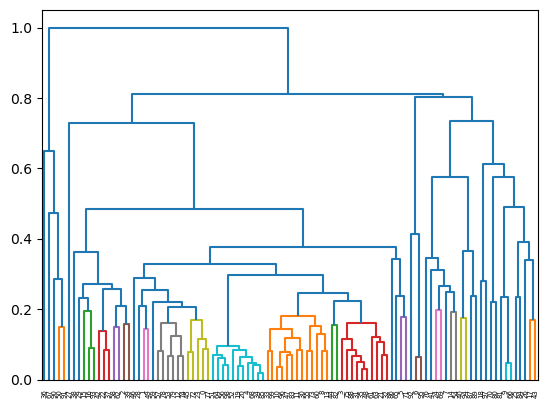

In [ ]:
# draw number of scale factors
sfs, means = lhc_lloyd(r'C:\Users\Alexm\OneDrive - Universität Wien\01_WINF\Praktikum1\Git2\Distant_SigMA\DistantSigMA\DistantSigMA\Data/Scale_factors/' + f'sfs_region_{chunk}.txt', num_sf)

# determine means for clusterer initialization
scale_factor_means = {'pos': {'features': ['ra', 'dec', 'parallax'], 'factor': list(means[:3])},
                      'vel': {'features': ['pmra', 'pmdec'], 'factor': list(means[3:])}}

# dict for final clustering
dict_final = dict(alpha=0.01,
                  beta=0.99,
                  knn_initcluster_graph=35,
                  KNN_list=[20],
                  sfs=sfs,
                  scaling=None,
                  bh_correction=False)

# Generate grouped solutions
grouped_labels = partial_clustering(df_input=df_chunk, sf_params=["ra", "dec", "parallax", "pmra", "pmdec"], parameter_dict=dict_final, mode="final",output_loc=result_path, column_means=scale_factor_means)

print(grouped_labels.shape)
# add the grouped solution labels to the dataframe holding the observations
df_final = df_chunk.copy()
for col in range(grouped_labels.shape[0]):
    df_final.loc[:, f"cluster_label_group_{col}"] = grouped_labels[col, :]

#df_final.to_csv(result_path+f"Region_{chunk}_sf_{num_sf}_grouped_solutions.csv")

### D) Tree/Graph

Below this point, the routine follows the minimal_usage.ipynb script from Alex.

In [ ]:
# Creating instances of custom classes
clusterMaster = ClusteringHandler()  # Manages cluster operations

#### Graph handling

In [ ]:
# make consensus over the grouped labels that came out of step C)
cc = ClusterConsensus(*grouped_labels)  # creates graph object cc.G
translation = cc.labels_bool_dict2arr

#rename the similarity in every edge to "weight"
for i, j, d in cc.G.edges(data=True):
    d['weight'] = d['similarity']
    d['weight_minor'] = d['similarity_minor']
    del d['similarity']
    del d['similarity_minor']

In [ ]:
#FIXME optimize me
# Jaccard (minor) distances
graph = NxGraphAssistant.remove_edges_with_minor(cc.G, 'weight', 0.3, 0.7)

#FIXME optimize me
# Merging thresholds for cliques (inner average Jaccard distance)
graph = NxGraphAssistant.analyze_cliques(graph, 0.95)

#### Plotting

In [ ]:
plotter = PlotHandler(translation,df_final, "")

In [ ]:
labels = clusterMaster.full_pipline_tree_hierachy(graph, Custom_Tree.alex_optimal, translation,plotter,2,1)

AttributeError: 'DataFrame' object has no attribute 'pmra_error'

In [ ]:



plotter.plot_labels_3D(labels)
plotter.plot_labels_2D(labels)